In [1]:
# === 1단계: Google Drive 마운트 및 기본 경로 설정 ===

# 1.1. Google Drive 마운트

from google.colab import drive
drive.mount('/content/drive')
print("Google Drive 마운트 완료.")

# 1.2. 데이터가 저장된 Google Drive 내의 기본 경로 설정
#       BASE_PATH = '/content/drive/MyDrive/aptos_data/'


BASE_PATH = '/content/drive/MyDrive/aptos_data/' #경로

# 설정된 경로가 실제로 존재하는지 확인
import os
if os.path.exists(BASE_PATH) and os.path.isdir(BASE_PATH):
    print(f"\n데이터 기본 경로가 확인되었습니다: {BASE_PATH}")
    print("\n'aptos_data' 폴더 내용 확인 (일부만):")
    # BASE_PATH 내의 파일 및 폴더 목록을 간단히 확인 (너무 많으면 일부만 출력)
    try:
        file_list = os.listdir(BASE_PATH)
        print(file_list[:10]) # 최대 10개 항목만 출력
        if 'train.csv' not in file_list:
            print("\n경고: 지정된 BASE_PATH에 'train.csv' 파일이 보이지 않습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"폴더 내용을 확인하는 중 오류 발생: {e}")
else:
    print(f"\n!!! 오류: 지정된 데이터 기본 경로 '{BASE_PATH}'를 찾을 수 없거나 폴더가 아닙니다!!!")
    # 심각한 오류이므로 이후 코드 실행에 문제가 생길 수 있습니다.
    # exit() # 필요시 주석 해제하여 여기서 중단

print("\n--- 1단계 완료: Google Drive 마운트 및 경로 설정 완료 ---")

Mounted at /content/drive
Google Drive 마운트 완료.

데이터 기본 경로가 확인되었습니다: /content/drive/MyDrive/aptos_data/

'aptos_data' 폴더 내용 확인 (일부만):
['test.csv', 'sample_submission.csv', 'train.csv', 'test_images', 'train_images']

--- 1단계 완료: Google Drive 마운트 및 경로 설정 완료 ---


In [2]:
# === 2단계: 필요한 라이브러리 불러오기 ===

# 2.1. 기본 데이터 처리 및 수치 연산 라이브러리
import pandas as pd
import numpy as np

# 2.2. 데이터 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 2.3. 이미지 처리 라이브러리
from PIL import Image

# 2.4. 파일 시스템 및 경로 관련 라이브러리 (os는 1단계에서 이미 import)
# import os # 이미 import 되어 있음

# 2.5. 머신러닝/딥러닝 관련 라이브러리 (TensorFlow & Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 2.6. 머신러닝 평가 및 데이터 분할 라이브러리 (Scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix

# 시각화 스타일 및 경고 메시지 처리 (선택 사항)
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print("--- 2단계 완료: 라이브러리 불러오기 완료 ---")

TensorFlow Version: 2.18.0
--- 2단계 완료: 라이브러리 불러오기 완료 ---


In [3]:
# === 3단계: 데이터 경로 재확인 및 학습용 CSV 파일 로드 ===

# 3.1. CSV 파일 및 이미지 폴더 경로 재설정 (BASE_PATH 기준)
# BASE_PATH가 1단계에서 올바르게 설정되었다고 가정합니다.
TRAIN_CSV_PATH = os.path.join(BASE_PATH, 'train.csv')
TEST_CSV_PATH = os.path.join(BASE_PATH, 'test.csv')
TRAIN_IMG_DIR = os.path.join(BASE_PATH, 'train_images')
TEST_IMG_DIR = os.path.join(BASE_PATH, 'test_images')

print(f"학습용 CSV 파일 경로: {TRAIN_CSV_PATH}")
print(f"학습 이미지 폴더 경로: {TRAIN_IMG_DIR}")

# 3.2. 학습용 CSV 파일 (train.csv) 로드 시도 및 파일 존재 여부 사전 확인
print("\n--- 학습용 CSV 파일 로드 시도 ---")
df_train = None # df_train 변수 초기화
if not os.path.exists(TRAIN_CSV_PATH):
    print(f"!!! 오류: '{TRAIN_CSV_PATH}' 경로에 'train.csv' 파일이 존재하지 않습니다 !!!")
    print("2. Google Drive의 해당 경로에 'train.csv' 파일이 실제로 존재하는지 확인하십시오.")
else:
    try:
        df_train = pd.read_csv(TRAIN_CSV_PATH)
        print(f"'{TRAIN_CSV_PATH}' 파일 로드 성공!")
        print(f"로드된 학습 데이터 샘플 수: {len(df_train)}")
    except Exception as e:
        print(f"오류: '{TRAIN_CSV_PATH}' 파일 로드 중 예외 발생 - {e}")

# df_train 변수가 정상적으로 생성되었는지 최종 확인
if df_train is None or df_train.empty:
    print("\n경고: df_train DataFrame이 정상적으로 로드되지 않았거나 비어있습니다.")
    print("반드시 1단계의 BASE_PATH 설정을 재확인")
else:
    print("\n--- 3단계 완료: CSV 파일 로드 및 경로 설정 완료 ---")

학습용 CSV 파일 경로: /content/drive/MyDrive/aptos_data/train.csv
학습 이미지 폴더 경로: /content/drive/MyDrive/aptos_data/train_images

--- 학습용 CSV 파일 로드 시도 ---
'/content/drive/MyDrive/aptos_data/train.csv' 파일 로드 성공!
로드된 학습 데이터 샘플 수: 3662

--- 3단계 완료: CSV 파일 로드 및 경로 설정 완료 ---


df_train DataFrame이 정상적으로 로드되었습니다. 데이터 탐색을 시작합니다.

=== DataFrame 기본 정보 (df_train.info()) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB

=== DataFrame 처음 5개 행 (df_train.head()) ===
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

=== 진단 단계(diagnosis)별 데이터 분포 (df_train['diagnosis'].value_counts()) ===
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64


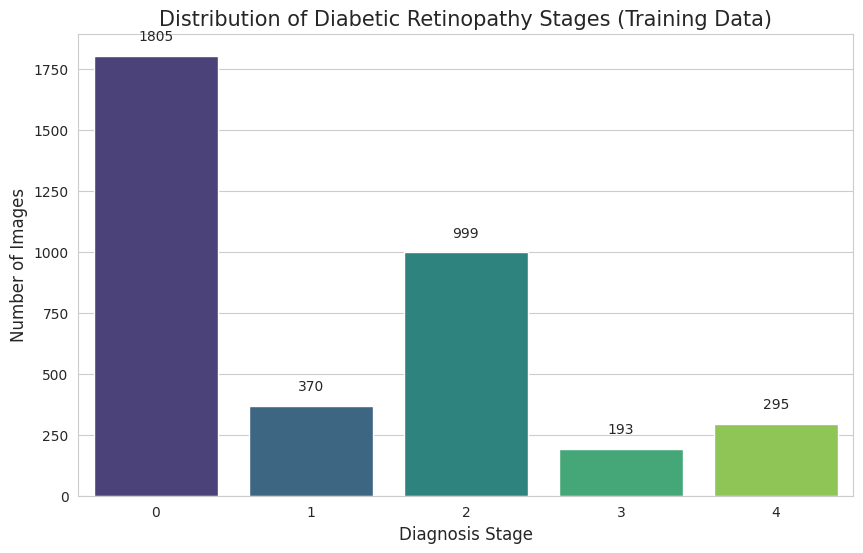


--- 4단계 완료: 학습 데이터 탐색 완료 ---


In [4]:
# === 4단계: 학습 데이터 (DataFrame) 살펴보기 ===

if df_train is None or df_train.empty:
    print("오류: df_train DataFrame이 존재하지 않거나 비어있습니다.")
else:
    print("df_train DataFrame이 정상적으로 로드되었습니다. 데이터 탐색\n")

    # 4.1. DataFrame의 기본 정보 출력
    print("=== DataFrame 기본 정보 (df_train.info()) ===")
    df_train.info()

    # 4.2. DataFrame의 처음 5개 행 출력
    print("\n=== DataFrame 처음 5개 행 (df_train.head()) ===")
    print(df_train.head())

    # 4.3. 진단 단계(diagnosis) 컬럼의 고유값 및 개수 확인
    print("\n=== 진단 단계(diagnosis)별 데이터 분포 (df_train['diagnosis'].value_counts()) ===")
    diagnosis_counts = df_train['diagnosis'].value_counts().sort_index()
    print(diagnosis_counts)

    # 4.4. 진단 단계별 분포 시각화
    plt.figure(figsize=(10, 6))
    sns.countplot(x='diagnosis', data=df_train, palette='viridis', order=diagnosis_counts.index)
    plt.title('Distribution of Diabetic Retinopathy Stages (Training Data)', fontsize=15)
    plt.xlabel('Diagnosis Stage', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(fontsize=10); plt.yticks(fontsize=10)
    for i, count in enumerate(diagnosis_counts):
        plt.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)
    plt.show()

    print("\n--- 4단계 완료: 학습 데이터 탐색 완료 ---")

In [5]:
# === 5단계: 이미지 파일 전체 경로 생성 ===

if df_train is None or df_train.empty:
    print("오류: df_train DataFrame이 존재하지 않거나 비어있습니다. 이전 단계.")
else:
    # 5.1. 'id_code'를 사용하여 전체 이미지 경로 생성
    df_train['image_path'] = df_train['id_code'].apply(lambda img_id: os.path.join(TRAIN_IMG_DIR, img_id + '.png'))

    print("=== 'image_path' 컬럼 추가 후 DataFrame 확인 (df_train.head()) ===")
    print(df_train.head())

    # 5.2. 생성된 이미지 경로 중 하나가 실제로 존재하는지 확인 (샘플 1개)
    if not df_train.empty:
        sample_image_path = df_train['image_path'].iloc[0]
        is_file_exist = os.path.exists(sample_image_path)
        print(f"\n샘플 이미지 경로: {sample_image_path}")
        print(f"해당 파일 존재 여부: {is_file_exist}")
        if not is_file_exist:
            print(f"경고: 샘플 이미지 파일({sample_image_path})을 찾을 수 없습니다.")
    else:
        print("\n경고: df_train DataFrame이 비어있어 샘플 이미지 경로를 확인할 수 없습니다.")

    print("\n--- 5단계 완료: 이미지 파일 전체 경로 생성 완료 ---")

=== 'image_path' 컬럼 추가 후 DataFrame 확인 (df_train.head()) ===
        id_code  diagnosis                                         image_path
0  000c1434d8d7          2  /content/drive/MyDrive/aptos_data/train_images...
1  001639a390f0          4  /content/drive/MyDrive/aptos_data/train_images...
2  0024cdab0c1e          1  /content/drive/MyDrive/aptos_data/train_images...
3  002c21358ce6          0  /content/drive/MyDrive/aptos_data/train_images...
4  005b95c28852          0  /content/drive/MyDrive/aptos_data/train_images...

샘플 이미지 경로: /content/drive/MyDrive/aptos_data/train_images/000c1434d8d7.png
해당 파일 존재 여부: True

--- 5단계 완료: 이미지 파일 전체 경로 생성 완료 ---


=== 학습 데이터에서 랜덤 샘플 이미지와 진단 단계 확인 ===


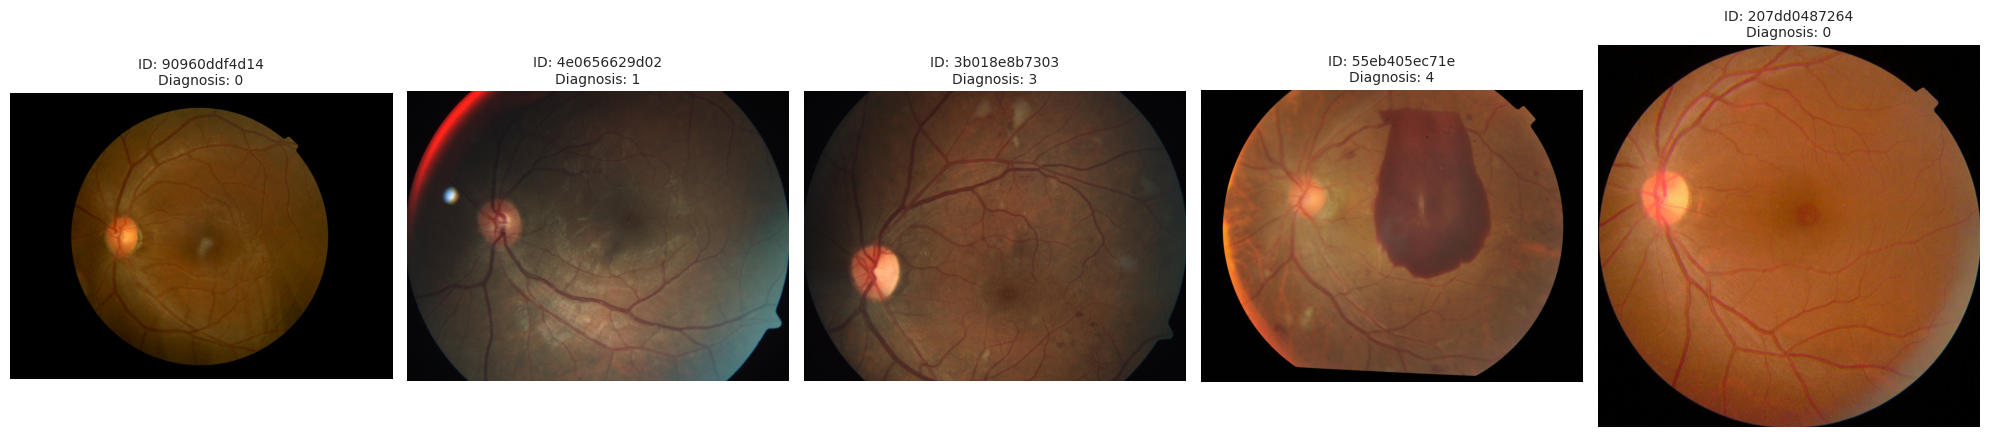


--- 6단계 완료: 샘플 이미지 시각화 완료 ---


In [6]:
# === 6단계: 샘플 이미지 시각화 ===

if df_train is None or df_train.empty or 'image_path' not in df_train.columns:
    print("오류: df_train DataFrame, 'image_path' 컬럼이 존재하지 않거나 비어있습니다. 이전 단계")
else:
    # 6.1. 랜덤하게 몇 개의 이미지를 골라 화면에 표시하는 함수 정의 (이전과 동일)
    def display_sample_images(df, num_samples=5, figsize=(20, 5)):
        if df.empty or num_samples == 0:
            print("표시할 데이터가 없거나 num_samples가 0입니다.")
            return
        plt.figure(figsize=figsize)
        sample_data = df.sample(min(num_samples, len(df)), random_state=42)
        for i, (index, row) in enumerate(sample_data.iterrows()):
            image_file_path = row['image_path']
            diagnosis_label = row['diagnosis']
            image_id = row['id_code']
            try:
                img = Image.open(image_file_path)
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img)
                plt.title(f"ID: {image_id}\nDiagnosis: {diagnosis_label}", fontsize=10)
                plt.axis('off')
            except FileNotFoundError:
                print(f"오류: 이미지 파일 '{image_file_path}'을(를) 찾을 수 없습니다.")
            except Exception as e:
                print(f"오류: 이미지 파일 '{image_file_path}'을(를) 여는 중 문제 발생 - {e}")
        plt.tight_layout()
        plt.show()

    print("=== 학습 데이터에서 랜덤 샘플 이미지와 진단 단계 확인 ===")
    display_sample_images(df_train, num_samples=5)

    print("\n--- 6단계 완료: 샘플 이미지 시각화 완료 ---")

In [7]:
# === 7단계: 모델 학습을 위한 주요 설정값 정의 ===

if df_train is None or df_train.empty:
    print("오류: df_train DataFrame이 존재하지 않거나 비어있습니다. 이전 단계")
else:
    IMG_SIZE = 224      # 모델에 입력될 이미지의 크기 (EfficientNetB0는 224x224 권장)
    BATCH_SIZE = 32     # 한 번의 학습 스텝에서 사용할 이미지 개수 (GPU 메모리에 따라 조절: 16, 32, 64)
    EPOCHS = 25         # 전체 데이터셋을 몇 번 반복하여 학습할 것인지 (EarlyStopping으로 조기 종료 가능)
    LEARNING_RATE = 1e-3 # 학습률 (모델 파라미터 업데이트 강도)
    NUM_CLASSES = 5     # 최종 분류할 클래스(진단 단계)의 개수 (0, 1, 2, 3, 4)
    SEED = 42           # 결과 재현성을 위한 랜덤 시드

    print(f"이미지 크기 (IMG_SIZE): {IMG_SIZE}x{IMG_SIZE}")
    print(f"배치 크기 (BATCH_SIZE): {BATCH_SIZE}")
    print(f"최대 에폭 수 (EPOCHS): {EPOCHS}")
    print(f"학습률 (LEARNING_RATE): {LEARNING_RATE}")
    print(f"클래스 개수 (NUM_CLASSES): {NUM_CLASSES}")
    print(f"랜덤 시드 (SEED): {SEED}")

    print("\n--- 7단계 완료: 주요 설정값 정의 완료 ---")

이미지 크기 (IMG_SIZE): 224x224
배치 크기 (BATCH_SIZE): 32
최대 에폭 수 (EPOCHS): 25
학습률 (LEARNING_RATE): 0.001
클래스 개수 (NUM_CLASSES): 5
랜덤 시드 (SEED): 42

--- 7단계 완료: 주요 설정값 정의 완료 ---


In [8]:
# === 8단계: 데이터 준비 (학습/검증 분할 및 레이블 형식 변환) ===

if df_train is None or df_train.empty:
    print("오류: df_train DataFrame이 존재하지 않거나 비어있습니다. 이전 단계 실행해주세요.")
else:
    # 8.1. 레이블(diagnosis)을 문자열(string) 타입으로 변환
    # ImageDataGenerator의 flow_from_dataframe 메소드는 y_col(레이블 컬럼)이 문자열일 때 더 안정적으로 동작합니다.
    df_train['diagnosis_str'] = df_train['diagnosis'].astype(str)
    print("=== 'diagnosis_str' 컬럼 추가 확인 (df_train.head()) ===")
    print(df_train[['id_code', 'diagnosis', 'diagnosis_str']].head())

    # 8.2. 학습 데이터와 검증 데이터 분할
    # stratify=df_train['diagnosis']: 원본 데이터의 클래스(진단 단계) 비율을 유지하면서 분할 (매우 중요!)
    train_df, valid_df = train_test_split(
        df_train,
        test_size=0.2,        # 검증 데이터로 사용할 비율 (20%)
        random_state=SEED,    # 재현성을 위한 랜덤 시드 고정
        stratify=df_train['diagnosis'] # 'diagnosis' 컬럼 기준으로 계층적 샘플링
    )

    print(f"\n=== 데이터 분할 결과 ===")
    print(f"전체 학습 데이터 수: {len(df_train)}")
    print(f"분할된 학습 데이터(train_df) 수: {len(train_df)}")
    print(f"분할된 검증 데이터(valid_df) 수: {len(valid_df)}")

    # 분할 후 각 세트의 클래스 비율 확인
    print("\n--- 학습 데이터(train_df) 클래스 분포 ---")
    print(train_df['diagnosis'].value_counts(normalize=True).sort_index()) # normalize=True: 비율로 표시
    print("\n--- 검증 데이터(valid_df) 클래스 분포 ---")
    print(valid_df['diagnosis'].value_counts(normalize=True).sort_index())

    print("\n--- 8단계 완료: 데이터 분할 및 레이블 변환 완료 ---")

=== 'diagnosis_str' 컬럼 추가 확인 (df_train.head()) ===
        id_code  diagnosis diagnosis_str
0  000c1434d8d7          2             2
1  001639a390f0          4             4
2  0024cdab0c1e          1             1
3  002c21358ce6          0             0
4  005b95c28852          0             0

=== 데이터 분할 결과 ===
전체 학습 데이터 수: 3662
분할된 학습 데이터(train_df) 수: 2929
분할된 검증 데이터(valid_df) 수: 733

--- 학습 데이터(train_df) 클래스 분포 ---
diagnosis
0    0.493001
1    0.101058
2    0.272789
3    0.052578
4    0.080574
Name: proportion, dtype: float64

--- 검증 데이터(valid_df) 클래스 분포 ---
diagnosis
0    0.492497
1    0.100955
2    0.272851
3    0.053206
4    0.080491
Name: proportion, dtype: float64

--- 8단계 완료: 데이터 분할 및 레이블 변환 완료 ---


In [9]:
# === 9단계: 데이터 제너레이터 생성 (ImageDataGenerator) ===

if 'train_df' not in locals() or 'valid_df' not in locals():
     print("오류: train_df 또는 valid_df가 존재하지 않습니다. 8단계를 먼저 성공적으로 실행")
else:
    # 9.1. 학습 데이터용 ImageDataGenerator 설정
    #    - efficientnet_preprocess_input: EfficientNet 모델에 맞는 방식으로 픽셀 값 스케일링 (중요!)
    #    - 데이터 증강(Data Augmentation) 옵션들: 과적합 방지 및 모델 일반화 성능 향상
    train_datagen = ImageDataGenerator(
        preprocessing_function=efficientnet_preprocess_input, # EfficientNet 전용 전처리 함수
        rotation_range=30,              # 랜덤 회전 각도 범위 (0 ~ 30도)
        width_shift_range=0.15,         # 랜덤 가로 이동 비율 (전체 너비의 15%)
        height_shift_range=0.15,        # 랜덤 세로 이동 비율 (전체 높이의 15%)
        shear_range=0.15,               # 랜덤 전단 변환 강도
        zoom_range=0.15,                # 랜덤 확대/축소 범위 (0.85 ~ 1.15배)
        horizontal_flip=True,           # 랜덤 좌우 반전
        fill_mode='reflect'             # 이미지 변환 시 경계 외부를 채우는 방식 ('nearest', 'constant', 'reflect', 'wrap')
    )

    # 9.2. 검증 데이터용 ImageDataGenerator 설정
    #    - 전처리만 적용 (EfficientNet 모델에 맞는 방식)
    #    - 데이터 증강은 적용하지 않음 (모델 성능을 일관되게 평가하기 위함)
    valid_datagen = ImageDataGenerator(
        preprocessing_function=efficientnet_preprocess_input # EfficientNet 전용 전처리 함수
    )

    # 9.3. DataFrame으로부터 데이터를 읽어오는 제너레이터 생성
    # flow_from_dataframe 메소드 사용
    print("\n--- 데이터 제너레이터 생성 중 ---")

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,             # 학습용 DataFrame
        x_col='image_path',             # 이미지 파일의 전체 경로가 담긴 컬럼명
        y_col='diagnosis_str',          # 문자열로 변환된 레이블 컬럼명
        target_size=(IMG_SIZE, IMG_SIZE), # 모든 이미지를 지정된 크기로 조절
        batch_size=BATCH_SIZE,          # 한 번에 생성할 이미지 배치 크기
        class_mode='categorical',       # 다중 클래스 분류 문제 (레이블이 원-핫 인코딩됨)
        shuffle=True,                   # 학습 데이터는 매 에폭마다 순서를 섞음
        seed=SEED                       # 재현성을 위한 랜덤 시드
    )

    validation_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,             # 검증용 DataFrame
        x_col='image_path',
        y_col='diagnosis_str',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,          # 검증 시에는 GPU 메모리가 허용한다면 더 큰 배치 사용 가능
        class_mode='categorical',
        shuffle=False                   # 검증 데이터는 순서를 섞지 않음 (일관된 평가를 위해)
    )

    # 생성된 제너레이터의 클래스 인덱스 확인 (폴더명/레이블명 순서대로 자동 할당됨)
    # 예: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
    print("\n학습 제너레이터 클래스 인덱스:", train_generator.class_indices)
    print("검증 제너레이터 클래스 인덱스:", validation_generator.class_indices)

    print("\n--- 9단계 완료: 데이터 제너레이터 생성 완료 ---")


--- 데이터 제너레이터 생성 중 ---
Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.

학습 제너레이터 클래스 인덱스: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
검증 제너레이터 클래스 인덱스: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

--- 9단계 완료: 데이터 제너레이터 생성 완료 ---


In [10]:
# === 10단계: 모델 구축 (전이 학습: Transfer Learning) ===

# 10.1. 사전 학습된 베이스 모델(EfficientNetB0) 로드
#    - include_top=False: ImageNet용 최종 분류 레이어(1000개 클래스)는 제외하고 가져옴
#    - weights='imagenet': ImageNet으로 학습된 가중치를 초기값으로 사용
#    - input_shape: 모델에 입력될 이미지의 형태 (높이, 너비, 채널 수)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3) # 3은 컬러 이미지(RGB)의 채널 수
)

# 10.2. 베이스 모델의 가중치 동결(Freeze)
#    - 사전 학습된 가중치가 초기 학습 단계에서 업데이트되지 않도록 설정
#    - 이렇게 하면 새로 추가하는 레이어들만 먼저 학습되어 안정적인 학습 가능
base_model.trainable = False

# 10.3. 새로운 모델 구성 (커스텀 분류기 추가)
# Keras의 함수형 API(Functional API)를 사용하여 모델을 구성합니다.

# 입력 레이어 정의
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')

# 베이스 모델을 통과시킵니다.
# training=False로 설정하여 BatchNormalization 레이어가 동결 상태에서도 통계를 업데이트하지 않도록 합니다.
x = base_model(inputs, training=False)

# 베이스 모델의 출력(특징 맵)에 GlobalAveragePooling2D 레이어를 적용하여 벡터 형태로 변환합니다.
x = GlobalAveragePooling2D(name='global_avg_pool')(x)

# 과적합 방지를 위해 Dropout 레이어 추가 (30%의 뉴런을 랜덤하게 비활성화)
x = Dropout(0.3, name='dropout_layer')(x) # Dropout 비율은 조절 가능 (0.2 ~ 0.5)

# 최종 출력 레이어(분류기):
# - NUM_CLASSES (5개) 만큼의 뉴런을 가짐
# - 활성화 함수는 'softmax' (다중 클래스 분류에서 각 클래스에 속할 확률을 출력)
outputs = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

# 10.4. 최종 모델 정의 (입력과 출력을 연결)
model = Model(inputs=inputs, outputs=outputs)

# 10.5. 모델 컴파일
#    - optimizer: 모델의 가중치를 업데이트하는 방법 (Adam 사용, 학습률 지정)
#    - loss: 손실 함수 (모델의 예측이 실제 값과 얼마나 다른지 측정)
#            'categorical_crossentropy'는 레이블이 원-핫 인코딩된 다중 클래스 분류 문제에 사용
#    - metrics: 학습 및 평가 과정에서 모니터링할 지표 ('accuracy' 등)
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # 정확도와 AUC 점수 모니터링
)

# 10.6. 모델 구조 요약 출력
print("\n=== 최종 모델 구조 요약 ===")
model.summary()

print("\n--- 10단계 완료: 모델 구축 완료 ---")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== 최종 모델 구조 요약 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- 10단계 완료: 모델 구축 완료 ---


In [11]:
# === 11단계: 콜백(Callbacks) 설정 (오류 수정) ===

# 이전 단계에서 NUM_CLASSES, LEARNING_RATE, SEED, IMG_SIZE, BATCH_SIZE, EPOCHS 등이 정의되었다고 가정합니다.
# 또한, model 변수가 10단계에서 성공적으로 컴파일되었다고 가정합니다.

# 11.1. ModelCheckpoint: 검증 세트에서 가장 좋은 성능을 보인 모델의 가중치를 저장
#    - filepath: 모델 가중치가 저장될 파일 경로. save_weights_only=True 이므로 '.weights.h5'로 끝나야 합니다.
#    - monitor='val_auc': 검증 세트의 AUC 점수를 기준으로 판단 (높을수록 좋음)
#    - save_best_only=True: 이전보다 성능이 개선되었을 때만 모델을 저장
#    - save_weights_only=True: 모델의 구조는 제외하고 가중치만 저장 (파일 크기 작음)
#    - mode='max': monitor 지표(val_auc)를 최대화하는 방향으로 판단 (loss는 'min')
#    - verbose=1: 저장될 때 메시지 출력
checkpoint_cb = ModelCheckpoint(
    'best_aptos_model_drive.weights.h5', # <--- 파일명 수정! '.weights.h5'로 끝나도록 변경
    monitor='val_auc',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# 11.2. EarlyStopping: 검증 세트의 성능이 일정 에폭 동안 개선되지 않으면 학습을 조기 종료
#    - monitor='val_auc': 검증 세트의 AUC 점수를 기준으로 판단
#    - patience=7: 성능 개선이 없는 에폭을 몇 번까지 기다릴지 (7 에폭 동안 개선 없으면 종료)
#    - restore_best_weights=True: 학습 종료 시 가장 좋았던 성능의 가중치로 모델을 복원
#    - mode='max'
#    - verbose=1
early_stopping_cb = EarlyStopping(
    monitor='val_auc',
    patience=7,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# 11.3. ReduceLROnPlateau: 검증 세트의 성능이 정체될 때 학습률(learning rate)을 동적으로 감소
#    - monitor='val_auc'
#    - factor=0.2: 학습률을 줄이는 비율 (현재 학습률 * 0.2)
#    - patience=3: 성능 개선이 없는 에폭을 몇 번 기다린 후 학습률을 줄일지
#    - min_lr=1e-6: 학습률의 하한선 (이 값보다 더 줄이지 않음)
#    - mode='max'
#    - verbose=1
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

# 사용할 콜백들을 리스트로 묶음
callbacks_list = [checkpoint_cb, early_stopping_cb, reduce_lr_cb]

print("--- 11단계 완료: 콜백 설정 완료 (ModelCheckpoint 파일명 수정) ---")

--- 11단계 완료: 콜백 설정 완료 (ModelCheckpoint 파일명 수정) ---


In [12]:
# === 12단계: 모델 학습 실행 ===

# 이전 단계에서 train_generator, validation_generator, model, callbacks_list,
# train_df, valid_df, BATCH_SIZE, EPOCHS 등이 정의되었다고 가정합니다.

if 'train_generator' not in locals() or \
   'validation_generator' not in locals() or \
   'model' not in locals() or \
   'callbacks_list' not in locals() or \
   'train_df' not in locals() or \
   'valid_df' not in locals() or \
   'BATCH_SIZE' not in locals() or \
   'EPOCHS' not in locals():
    print("오류: 학습에 필요한 변수가 준비되지 않았습니다. 이전 단계를 확인")
else:
    print("\n--- 모델 학습 시작 ---")
    print(f"학습 데이터 스텝 수 (steps_per_epoch): {len(train_df) // BATCH_SIZE}")
    print(f"검증 데이터 스텝 수 (validation_steps): {len(valid_df) // BATCH_SIZE}")

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_df) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(valid_df) // BATCH_SIZE,
        callbacks=callbacks_list,
        verbose=1
    )

    print("\n--- 모델 학습 완료 ---")
    # EarlyStopping 콜백의 restore_best_weights=True 설정에 의해,
    # 자동으로 가장 좋았던 성능의 가중치가 모델에 로드되어 있습니다.
    # 저장된 파일명은 11단계에서 'best_aptos_model_drive.weights.h5'로 지정했습니다.
    print("가장 성능이 좋았던 모델 가중치가 'best_aptos_model_drive.weights.h5' 파일로 저장되었을 수 있으며,")
    print("EarlyStopping에 의해 해당 가중치가 현재 모델에 복원되었습니다.")


--- 모델 학습 시작 ---
학습 데이터 스텝 수 (steps_per_epoch): 91
검증 데이터 스텝 수 (validation_steps): 22
Epoch 1/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5580 - auc: 0.8136 - loss: 1.1593 
Epoch 1: val_auc improved from -inf to 0.90751, saving model to best_aptos_model_drive.weights.h5
91/91 ━━━━━━━━━━━━━━━━━━━━ 1955s 21s/step - accuracy: 0.5589 - auc: 0.8142 - loss: 1.1575 - val_accuracy: 0.6761 - val_auc: 0.9075 - val_loss: 0.8563 - learning_rate: 0.0010
Epoch 2/25
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:59 1s/step - accuracy: 0.6562 - auc: 0.8595 - loss: 1.0425
Epoch 2: val_auc improved from 0.90751 to 0.90967, saving model to best_aptos_model_drive.weights.h5
91/91 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.6562 - auc: 0.8595 - loss: 1.0425 - val_accuracy: 0.6776 - val_auc: 0.9097 - val_loss: 0.8495 - learning_rate: 0.0010
Epoch 3/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7343 - auc: 0.9290 - loss: 0.7653
Epoch 3: val_auc improved from 0.90967 to 0.92997, saving model to best_ap


--- 학습 결과 시각화 ---


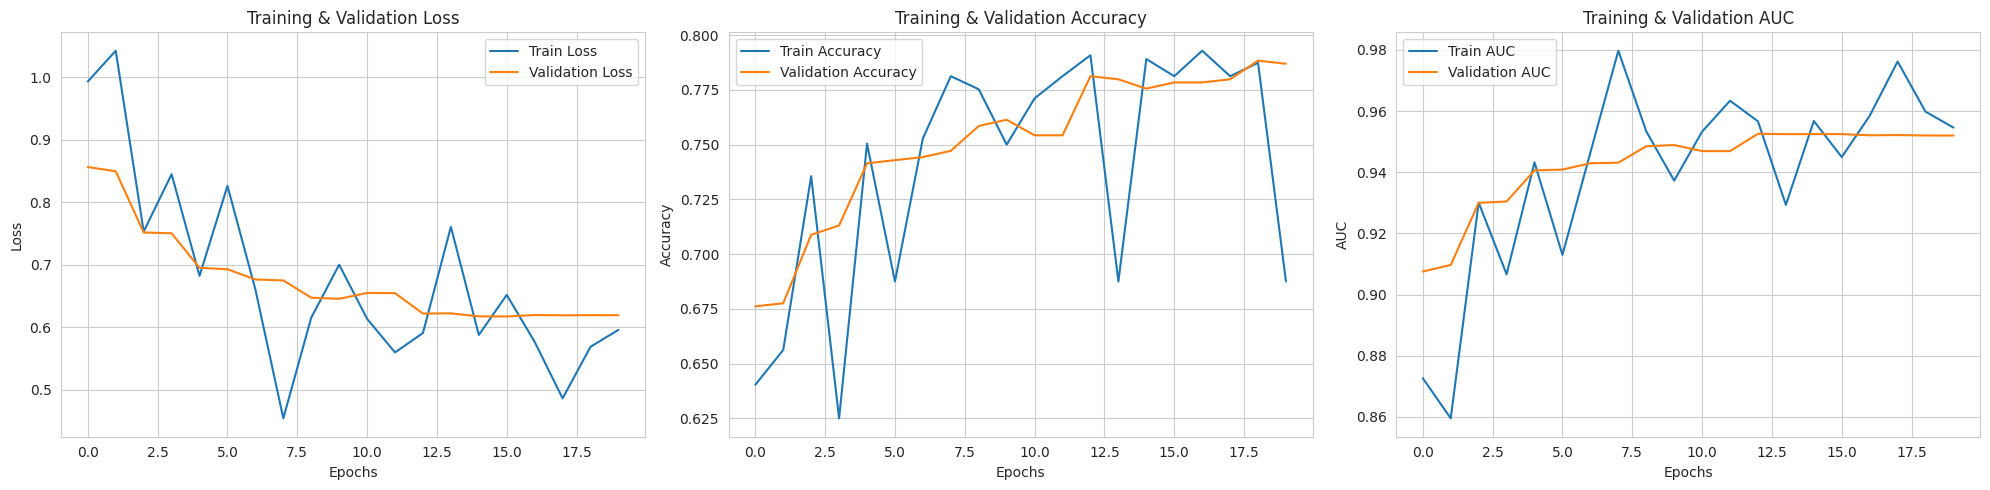


--- 검증 데이터 최종 성능 평가 ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7724 - auc: 0.9475 - loss: 0.6462

== 평가 결과 요약 ==
loss: 0.6217
compile_metrics: 0.7812

--- 검증 데이터 예측 생성 중 (시간이 다소 소요될 수 있습니다)... ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step

Validation Quadratic Weighted Kappa: 0.8183

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       361
           1       0.59      0.27      0.37        74
           2       0.62      0.91      0.74       200
           3       0.86      0.15      0.26        39
           4       0.68      0.22      0.33        59

    accuracy                           0.78       733
   macro avg       0.73      0.50      0.53       733
weighted avg       0.78      0.78      0.74       733


=== Confusion Matrix ===


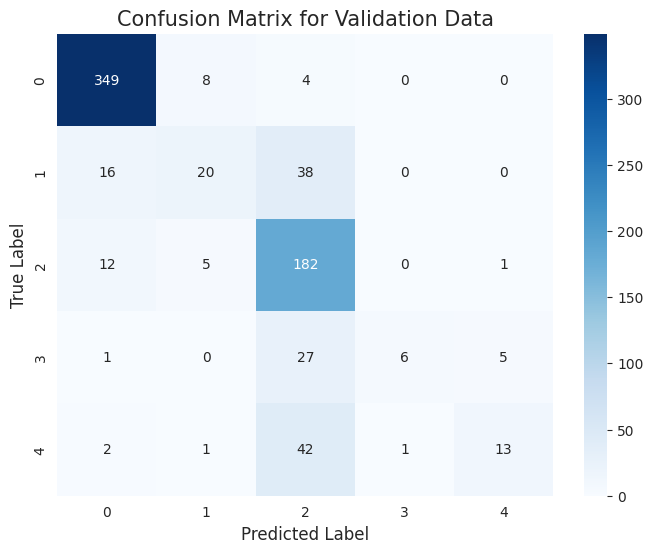


--- 13단계 완료: 학습 결과 시각화 및 평가 완료 ---


In [13]:
# === 13단계: 학습 결과 시각화 및 평가 ===

if 'history' not in locals() or \
   'model' not in locals() or \
   'validation_generator' not in locals() or \
   'valid_df' not in locals() or \
   'BATCH_SIZE' not in locals():
    print("오류: 학습 결과(history), 모델, 또는 검증 관련 변수가 존재하지 않습니다. 12단계를 먼저 실행")
else:
    print("\n--- 학습 결과 시각화 ---")

    # 13.1. 학습 과정 시각화 (Loss, Accuracy, AUC)
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Loss 그래프
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].set_xlabel('Epochs'); axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy 그래프
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].set_xlabel('Epochs'); axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # AUC 그래프
    if 'auc' in history.history and 'val_auc' in history.history:
        axes[2].plot(history.history['auc'], label='Train AUC')
        axes[2].plot(history.history['val_auc'], label='Validation AUC')
        axes[2].set_title('Training & Validation AUC')
        axes[2].set_xlabel('Epochs'); axes[2].set_ylabel('AUC')
        axes[2].legend()
    else:
        axes[2].text(0.5, 0.5, 'AUC data not available\n(Ensure "auc" metric was compiled)', ha='center', va='center')
        axes[2].set_title('AUC Plot')

    plt.tight_layout()
    plt.show()

    # 13.2. 검증 데이터로 최종 성능 평가
    print("\n--- 검증 데이터 최종 성능 평가 ---")
    # 만약 EarlyStopping에 의해 최적 가중치가 복원되지 않았다면, 또는 명시적으로 로드하고 싶다면:
    # print("최적 가중치 로드 중: best_aptos_model_drive.weights.h5")
    # model.load_weights('best_aptos_model_drive.weights.h5') # 파일명 확인

    results = model.evaluate(
        validation_generator,
        steps=len(valid_df) // BATCH_SIZE,
        verbose=1
    )

    print("\n== 평가 결과 요약 ==")
    for name, value in zip(model.metrics_names, results):
        print(f"{name}: {value:.4f}")

    # 13.3. 추가 평가 지표 계산 (Cohen's Kappa, Classification Report, Confusion Matrix)
    print("\n--- 검증 데이터 예측 생성 중 (시간이 다소 소요될 수 있습니다)... ---")
    validation_generator.reset()
    import math
    val_steps = math.ceil(len(valid_df) / BATCH_SIZE)
    predictions = model.predict(validation_generator, steps=val_steps, verbose=1)
    predicted_classes_indices = np.argmax(predictions, axis=1)
    true_classes_indices = validation_generator.classes[:len(predicted_classes_indices)]
    class_labels_str = list(validation_generator.class_indices.keys())

    kappa = cohen_kappa_score(true_classes_indices, predicted_classes_indices, weights='quadratic')
    print(f"\nValidation Quadratic Weighted Kappa: {kappa:.4f}")

    print("\n=== Classification Report ===")
    print(classification_report(true_classes_indices, predicted_classes_indices, target_names=class_labels_str))

    print("\n=== Confusion Matrix ===")
    cm = confusion_matrix(true_classes_indices, predicted_classes_indices)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels_str, yticklabels=class_labels_str)
    plt.title('Confusion Matrix for Validation Data', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    print("\n--- 13단계 완료: 학습 결과 시각화 및 평가 완료 ---")